In [22]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/lmitchell33/Fluid-Solutions-ML/refs/heads/main/data/processed/FINAL_TRAINING_DATA.csv")

In [23]:
# separte the data into X (input) and y (label)
X, y = data.drop(columns=['label', 'Unnamed: 0']).to_numpy(), data['label'].to_numpy()

In [24]:
X, y

(array([[ 17. ,  73. ,  83. , ..., 131. ,  98. ,  76. ],
        [ 20. ,  86. ,  89. , ..., 147. ,  98. ,  89. ],
        [ 16. ,  67. , 107. , ..., 148. ,  97. ,  64. ],
        ...,
        [ 21.3,  92.2,  74.2, ..., 118.2, 100. ,  55.8],
        [ 20.2,  91.6,  77.8, ..., 116.4,  97. ,  54.3],
        [ 22. , 100. ,  77. , ..., 117.8,  98. ,  54.7]]),
 array(['low', 'low', 'low', ..., 'normal', 'normal', 'normal'],
       dtype=object))

In [25]:
# transfer the categorical data into numerical (models can only understand numerical data)
label_encoder = LabelEncoder()
y_labeled = label_encoder.fit_transform(y)

# Labels are as follows:
# high -> 0
# low -> 1
# normal -> 2

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'high': np.int64(0), 'low': np.int64(1), 'normal': np.int64(2)}

In [26]:
feature_names = data.drop(columns=['label', 'Unnamed: 0']).columns.to_list()
feature_names

['respiratory_rate',
 'heart_rate',
 'mean_arterial_pressure',
 'diastolic_arterial_pressure',
 'systolic_arterial_pressure',
 'spo2',
 'pulse_pressure']

In [27]:
# randomly split the dat into training and testing subsets
# this is a 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_labeled, test_size=0.20, random_state=42)

In [28]:
X_train, y_train

(array([[ 18. ,  66. ,  77.8, ..., 117.7,  95. ,  52.1],
        [ 20. ,  90. ,  76.4, ..., 118.4,  97. ,  54. ],
        [ 28. , 108. ,  75.9, ..., 118.9,  98. ,  55.6],
        ...,
        [ 20. ,  78. ,  76.3, ..., 118.4,  99. ,  55.4],
        [ 22. , 104. ,  64. , ...,  95. ,  97. ,  44. ],
        [ 27. ,  76. ,  75.2, ..., 116.5,  96. ,  53.1]]),
 array([2, 2, 2, ..., 2, 1, 2]))

In [29]:
# create a parameter grid to perfomr the grid search with (xgboost paramters this time)
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 4, 5, 10],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3],
#     'reg_lambda': [0.1, 1], # Ridge regression
# }
param_grid = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.01],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'min_child_weight': [1],
    'reg_lambda': [1], # Ridge regression
}

In [30]:
# decalre the model NOTE: this model automatically uses logloss for the validation data
xgb_rf = xgb.XGBClassifier(random_state=42, num_class=3, objective='multi:softmax')
grid_search = GridSearchCV(xgb_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, subsample=1.0; total time=   0.2s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0],
                         'learning_rate': [0.01], 'max_depth': [3],
                         'min_child_weight': [1], 'n_estimators': [100],
                         'reg_lambda': [1], 'subsample': [1.0]},
             verbose=2)

In [31]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_lambda': 1, 'subsample': 1.0}


In [32]:
best_xg_boost = grid_search.best_estimator_
best_params = grid_search.best_params_

In [33]:
y_pred = best_xg_boost.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.8392494929006086


In [34]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       292
           1       0.62      0.99      0.76       506
           2       1.00      0.98      0.99      1174

    accuracy                           0.84      1972
   macro avg       0.54      0.66      0.58      1972
weighted avg       0.75      0.84      0.78      1972



/home/lmitchell/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lmitchell/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lmitchell/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from collections import Counter
predictions = best_xg_boost.predict(X_test)
print(Counter(predictions))
print(Counter(y_test))

Counter({np.int32(2): 1158, np.int32(1): 814})
Counter({np.int64(2): 1174, np.int64(1): 506, np.int64(0): 292})


In [35]:
# best_xg_boost.save_model("/content/xgboost_model.json")

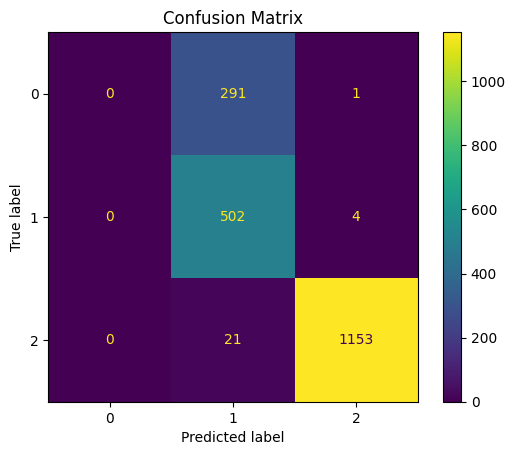

In [36]:
# create a confusion matrix to see how well the model distinguishes between classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Labels are as follows:
# high -> 0
# low -> 1
# normal -> 2

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

/home/lmitchell/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lmitchell/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lmitchell/.local/lib/python3.10/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/home/lmitchell/.local/lib/python3.10/site-packages/xgboost/sklearn.py", line 1559, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique

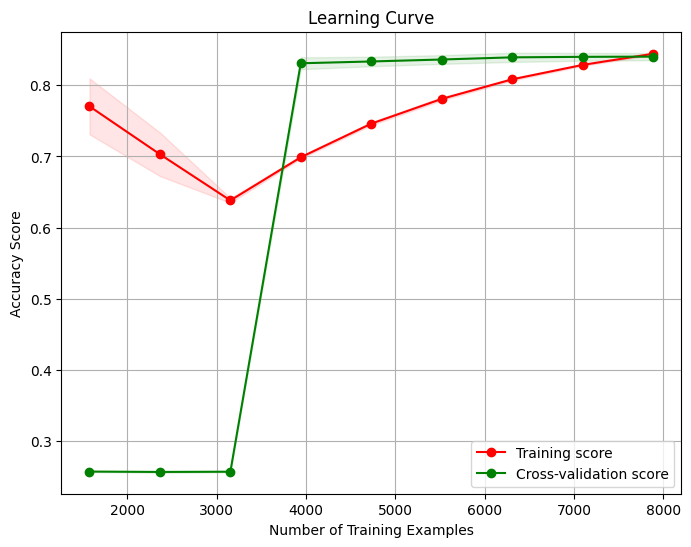

In [37]:
# Check to see how the model is fitting to the data by plotting the learning curve
from sklearn.model_selection import learning_curve
import numpy as np

best_model = xgb.XGBClassifier(**best_params, random_state=42)

train_sizes, train_scores, cv_scores = learning_curve(
    best_model, X, y_labeled, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)
cv_scores_std = np.std(cv_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, cv_scores_mean - cv_scores_std,
                 cv_scores_mean + cv_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, cv_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

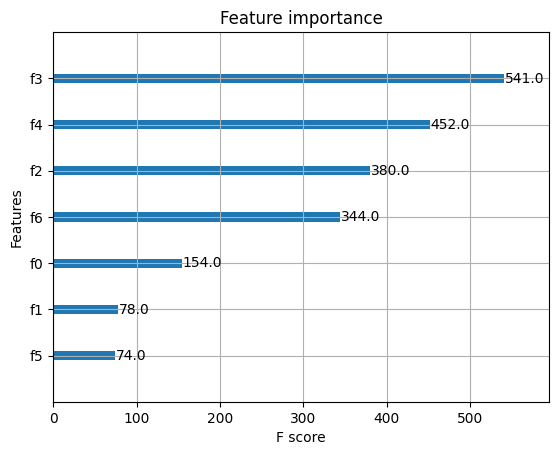

In [38]:
# found this in the documentation and I figured I would try it
xgb.plot_importance(best_xg_boost)